In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.basemap import Basemap

In [3]:
import warnings
warnings.filterwarnings('ignore')
# Who needs warnings anyhow

### Constants

In [4]:
EARTH_R = 6_371_000     # Earth radius in meters
OMEGA = 2*math.pi / (1436*60)  # Angular velocity of Earth
GM = 9.807 * EARTH_R**2     # G * M

### Plotting

In [5]:
def plot_solution(x, y, z, view_lim=(-EARTH_R / 2 + 100*1000, EARTH_R / 2 + 100*1000), save_fig=None):
    views =  [(-20, 10, 30)]
    
    fig, ax = plt.subplots(len(views), 1, subplot_kw={'projection': '3d'}, figsize=(3.5, 3.5), constrained_layout=True)
    min_of_view, max_of_view = view_lim
    for coord in [x, y, z]:
        min_of_view = min(min_of_view, min(coord))
        max_of_view = max(max_of_view, max(coord))
    
    # Create a meshgrid of spherical coordinates
    phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
    earth_x = EARTH_R * np.sin(theta) * np.cos(phi)
    earth_y = EARTH_R * np.sin(theta) * np.sin(phi)
    earth_z = EARTH_R * np.cos(theta)
    
    for idx, view in enumerate(views):
        # Plot the sphere
        ax.plot_surface(earth_x, earth_y, earth_z, color='b', alpha=0.3)
        
        s = 3
        ax.scatter(x, y, z, color='blue', s=s, label='Satellite Trajectory')
        ax.scatter(x[0], y[0], z[0], label='Start', color='green', s=s*6)  # Mark the starting point
        ax.scatter(x[-1], y[-1], z[-1], label='End', color='red', s=s*6)  # Mark the ending point
        ax.azim, ax.dist, ax.elev = view
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim((min_of_view, max_of_view))
        ax.set_ylim((min_of_view, max_of_view))
        ax.set_zlim((min_of_view, max_of_view))
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.get_yaxis().get_offset_text().set_visible(False)
    ax.get_zaxis().get_offset_text().set_visible(False)
    if save_fig:
        plt.savefig(f"figures/{save_fig}")
    plt.show()
    
def colatitude_to_latitude(colatitude):
    return 90.0 - colatitude

def plot_trajectory(latitude, longitude, save_fig):    
    # Create a Basemap instance for the world map
    for m in [
        Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c'), 
        Basemap(projection='eck4', lon_0=0, resolution='c')
    ]:
        plt.figure(figsize=(3.5, 3.5))
        # Plot continents and coastlines
        m.drawcoastlines()
        m.drawcountries()
        m.fillcontinents(color='coral')

        m.scatter(longitude, latitude, latlon=True, c='blue', s=0.3, label='Satellite Trajectory')

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend(loc='upper left')
        if save_fig:
            plt.savefig(f"figures/{save_fig}_{m.projection}")
        plt.show()
    
def plot_ground_track(theta, phi):
    phi = (phi - math.pi) % 2*math.pi 
    theta = theta % math.pi
    
    # Plot the ground track
    plt.scatter(phi, theta, marker='o', color='red', label='Ground Track')
    
    # Set labels and title
    plt.xlabel('phi')
    plt.ylabel('theta')
    
    # Show a legend
    plt.legend()
    
    # Show the plot
    plt.show()

### Differential equations of motion

In [8]:
def equations_of_motion_inertial(t, y):
    r, dr_dt, theta, dtheta_dt, phi, dphi_dt, a = y
    
    r_dotdot = r * dtheta_dt**2 + r * math.sin(theta)**2 * dphi_dt**2 -GM/r**2
    theta_dot_dot = math.sin(theta) * math.cos(theta) * dphi_dt**2 -2 * dr_dt / r * dtheta_dt
    phi_dot_dot = -2 * dr_dt / r * dphi_dt - 2 * (math.cos(theta)/math.sin(theta))*dphi_dt*dtheta_dt
    return [dr_dt, r_dotdot, dtheta_dt, theta_dot_dot, dphi_dt, phi_dot_dot, a]

t_prev = 0
def equations_of_motion_ecef(t, y):
    global t_prev
    r, dr_dt, theta, dtheta_dt, phi, dphi_dt, a = y
    OMEGA_adj = OMEGA * (t - t_prev)
    
    r_dot_dot = r * dtheta_dt**2 + r*math.sin(theta)**2 *(dphi_dt**2 + 2*dphi_dt*OMEGA_adj + OMEGA_adj**2) - GM/r**2
    theta_dot_dot = -2 * dr_dt/r * dtheta_dt + math.sin(theta)*math.cos(theta)*(dphi_dt**2 + 2*dphi_dt*OMEGA_adj + OMEGA_adj**2)
    phi_dot_dot = -2 * dr_dt/r * (dphi_dt + OMEGA_adj) - 2 * math.cos(theta)/math.sin(theta) * (dphi_dt + OMEGA_adj)*dtheta_dt
    
    t_prev = t
    return [dr_dt, r_dot_dot, dtheta_dt, theta_dot_dot, dphi_dt, phi_dot_dot, a]

### Scipy solvers for equations of motion

In [15]:
def solve_for_3d_initial_inertial(r_init, dr_dt_int, theta_init, dtheta_dt_init, phi_init, dphi_dt_init, a=0, sampling=1000, start=0, end=50, view_lim=None, save_fig=None, plot=True):
    if view_lim is None:
        view_lim = (-r_init, r_init)
    if save_fig:
        save_fig = f"{save_fig}_ic"
    initial_conditions = [r_init, dr_dt_int, theta_init, dtheta_dt_init, phi_init, dphi_dt_init, a]
    solution = solve_ivp(equations_of_motion_inertial, (start, end), initial_conditions, t_eval=np.linspace(start, end, sampling), method="DOP853")
    time = solution.t
    radial_coordinates, theta_coordinates, phi_coordinates  = solution.y[0], solution.y[2], solution.y[4]
    x = radial_coordinates * np.cos(phi_coordinates)*np.sin(theta_coordinates)
    y = radial_coordinates * np.sin(phi_coordinates)*np.sin(theta_coordinates)
    z = radial_coordinates * np.cos(theta_coordinates)
    if plot:
        plot_solution(x, y, z, view_lim, save_fig)
    return solution

def solve_for_3d_ecef(r_init, dr_dt_int, theta_init, dtheta_dt_init, phi_init, dphi_dt_init, a=0, sampling=1000, start=0, end=50, view_lim=None, save_fig=None, method="DOP853", plot=True):
    global t_prev
    t_prev = 0
    if view_lim is None:
        view_lim = (-r_init, r_init)
    if save_fig:
        save_fig = f"{save_fig}_ecef"
    initial_conditions = [r_init, dr_dt_int, theta_init, dtheta_dt_init, phi_init, dphi_dt_init, a]
    solution = solve_ivp(equations_of_motion_ecef, (start, end), initial_conditions, t_eval=np.linspace(start, end, sampling), method=method)
    time = solution.t
    radial_coordinates, theta_coordinates, phi_coordinates  = solution.y[0], solution.y[2], solution.y[4]
    phi_adjusted = phi_coordinates - OMEGA * time
    if plot:
        plot_trajectory(colatitude_to_latitude(np.degrees(theta_coordinates)), np.degrees(phi_adjusted), save_fig)
    return solution

### Examples with plots

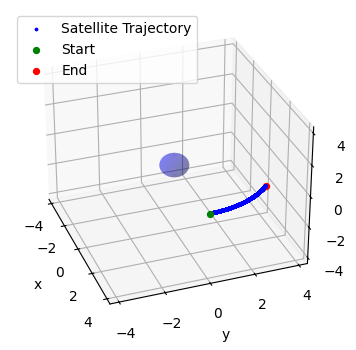

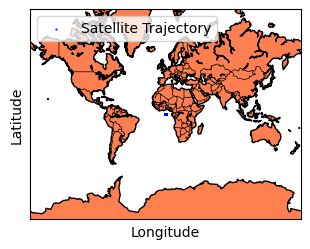

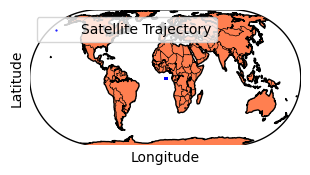

In [16]:
initial = (EARTH_R + 35786*1000, 0, math.pi/2, 0, 0, 2*math.pi/(1436*60), 0, 10000, 0, 180*60)
fig_name = "geo_stationary"
solve_for_3d_initial_inertial(*initial, save_fig=fig_name)
solve_for_3d_ecef(*initial, save_fig=fig_name);

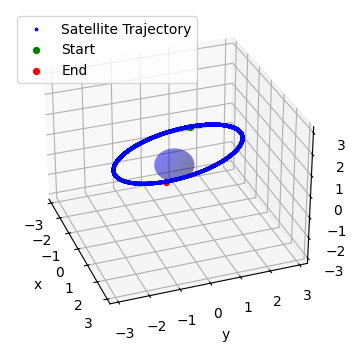

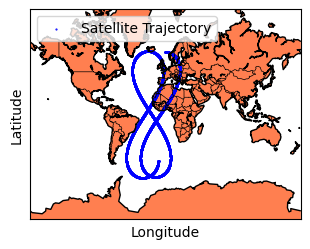

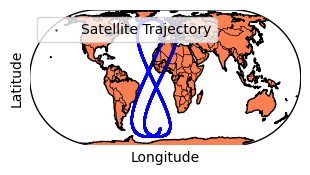

In [17]:
spd = 2*math.pi / (521*60)
initial = (EARTH_R + 25000*1000, 0, np.radians(90-63.4), 0, 0, spd, 0, 10000, 0, 1436*60)
fig_name = "number_8_orbit"
solve_for_3d_initial_inertial(*initial, save_fig=fig_name)
solve_for_3d_ecef(*initial, save_fig=fig_name, method="RK45");

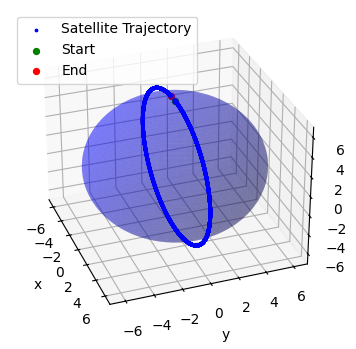

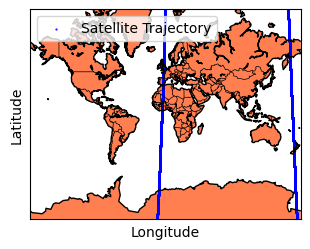

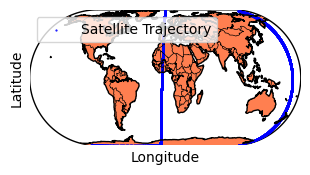

In [18]:
initial = (EARTH_R + 300*1000, 0, 0.00001, 2*math.pi / (90*60), 0, 0, 0, 10000, 0, 90*60)
fig_name = "leo_polar_300"
solve_for_3d_initial_inertial(*initial, save_fig=fig_name)
solve_for_3d_ecef(*initial, save_fig=fig_name);

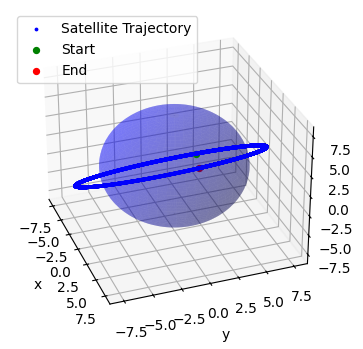

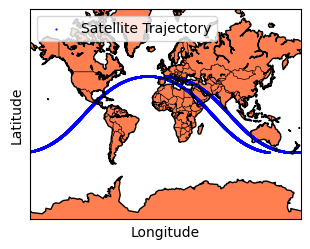

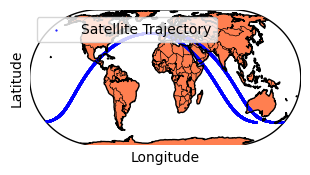

In [19]:
initial = (EARTH_R + 1000*1000, 0, math.pi / 4, 0, 0, 2*math.pi / (70*60), 0, 10000, 0, 3*60*60)
fig_name = "inclined_1000"
solve_for_3d_initial_inertial(*initial, save_fig=fig_name)
solve_for_3d_ecef(*initial, save_fig=fig_name);

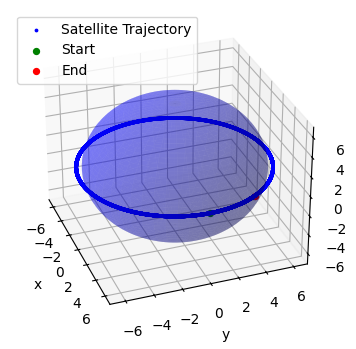

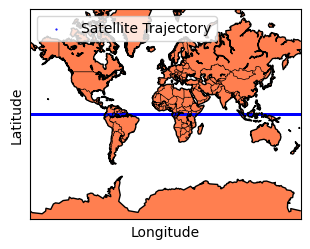

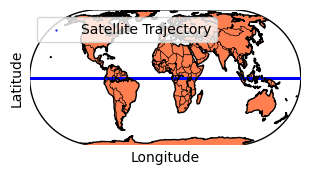

In [20]:
initial = (EARTH_R + 300*1000, 0, math.pi / 2, 0, 0, 2*math.pi / (90*60), 0, 10000, 0, 100*60)
fig_name = "leo_300"
solve_for_3d_initial_inertial(*initial, save_fig=fig_name)
solve_for_3d_ecef(*initial, save_fig=fig_name);

### Animations

In [21]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animation_3d(x, y, z, save_fig=None):
    views =  [(-20, 10, 30)]
    fig, ax = plt.subplots(len(views), 1, subplot_kw={'projection': '3d'}, figsize=(3.5, 3.5))

    min_of_view, max_of_view = (-EARTH_R / 2 + 100*1000, EARTH_R / 2 + 100*1000)
    for coord in [x, y, z]:
        min_of_view = min(min_of_view, min(coord))
        max_of_view = max(max_of_view, max(coord))
    
    # Create a meshgrid of spherical coordinates
    phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
    earth_x = EARTH_R * np.sin(theta) * np.cos(phi)
    earth_y = EARTH_R * np.sin(theta) * np.sin(phi)
    earth_z = EARTH_R * np.cos(theta)
    
    for idx, view in enumerate(views):
        # Plot the sphere
        ax.plot_surface(earth_x, earth_y, earth_z, color='b', alpha=0.3)
        s = 3
        ax.azim, ax.dist, ax.elev = view
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim((min_of_view, max_of_view))
        ax.set_ylim((min_of_view, max_of_view))
        ax.set_zlim((min_of_view, max_of_view))
    plt.grid(True)
    plt.tight_layout()
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.get_yaxis().get_offset_text().set_visible(False)
    ax.get_zaxis().get_offset_text().set_visible(False)
    
    # Only every 100th point is shown
    frame_sampling = 100
    
    def animation(i):
        i = frame_sampling * i
        ax.scatter(x[i], y[i], z[i], color='blue', s=s, label='Satellite Trajectory')
    
    ani = FuncAnimation(fig, animation, frames=len(x)//frame_sampling, interval=100)
    ani.save(filename=f"animations/{save_fig}_3d.gif", writer="pillow")
    
def animation_2d(latitude, longitude, save_fig=None):
     for m in [
        Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c'), 
        Basemap(projection='eck4', lon_0=0, resolution='c')
    ]:
        fig = plt.figure(figsize=(3.5, 3.5))
        # Plot continents and coastlines
        m.drawcoastlines()
        m.drawcountries()
        m.fillcontinents(color='coral')

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        
        # Only every 100th point is shown
        frame_sampling = 100
        
        def animation(i):
            i = frame_sampling * i
            m.scatter(longitude[i], latitude[i], latlon=True, c='blue', s=0.8, label='Satellite Trajectory')
        
        ani = FuncAnimation(fig, animation, frames=len(latitude)//frame_sampling, interval=100)
        ani.save(filename=f"animations/{save_fig}_{m.projection}_2d.gif", writer="pillow")

### Examples with animations

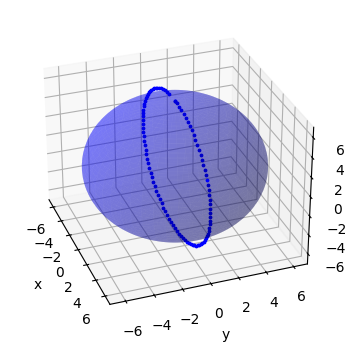

In [22]:
initial = (EARTH_R + 300*1000, 0, 0.00001, 2*math.pi / (90*60), 0, 0, 0, 10000, 0, 90*60)
fig_name = "leo_polar_300"
solution = solve_for_3d_initial_inertial(*initial, save_fig=fig_name, plot=False)
radial_coordinates, theta_coordinates, phi_coordinates  = solution.y[0], solution.y[2], solution.y[4]
x = radial_coordinates * np.cos(phi_coordinates)*np.sin(theta_coordinates)
y = radial_coordinates * np.sin(phi_coordinates)*np.sin(theta_coordinates)
z = radial_coordinates * np.cos(theta_coordinates)
animation_3d(x, y, z, save_fig=fig_name)

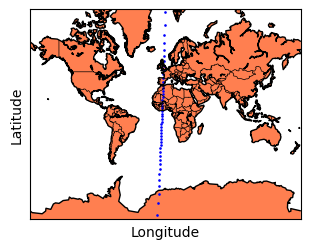

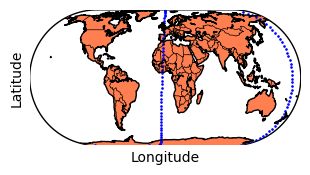

In [23]:
initial = (EARTH_R + 300*1000, 0, 0.00001, 2*math.pi / (90*60), 0, 0, 0, 10000, 0, 90*60)
fig_name = "leo_polar_300"
solution = solve_for_3d_ecef(*initial, save_fig=fig_name, plot=False)
time = solution.t
_, theta_coordinates, phi_coordinates  = solution.y[0], solution.y[2], solution.y[4]
phi_adjusted = phi_coordinates - OMEGA * time
animation_2d(colatitude_to_latitude(np.degrees(theta_coordinates)), np.degrees(phi_adjusted), save_fig=fig_name)

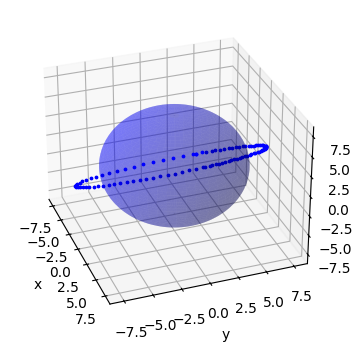

In [24]:
initial = (EARTH_R + 1000*1000, 0, math.pi / 4, 0, 0, 2*math.pi / (70*60), 0, 10000, 0, 3*60*60)
fig_name = "inclined_1000"
solution = solve_for_3d_initial_inertial(*initial, save_fig=fig_name, plot=False)
radial_coordinates, theta_coordinates, phi_coordinates  = solution.y[0], solution.y[2], solution.y[4]
x = radial_coordinates * np.cos(phi_coordinates)*np.sin(theta_coordinates)
y = radial_coordinates * np.sin(phi_coordinates)*np.sin(theta_coordinates)
z = radial_coordinates * np.cos(theta_coordinates)
animation_3d(x, y, z, save_fig=fig_name)

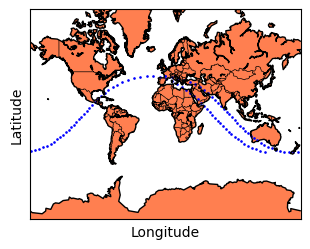

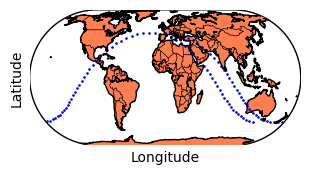

In [25]:
initial = (EARTH_R + 1000*1000, 0, math.pi / 4, 0, 0, 2*math.pi / (70*60), 0, 10000, 0, 3*60*60)
fig_name = "inclined_1000"
solution = solve_for_3d_ecef(*initial, save_fig=fig_name, plot=False)
time = solution.t
_, theta_coordinates, phi_coordinates  = solution.y[0], solution.y[2], solution.y[4]
phi_adjusted = phi_coordinates - OMEGA * time
animation_2d(colatitude_to_latitude(np.degrees(theta_coordinates)), np.degrees(phi_adjusted), save_fig=fig_name)

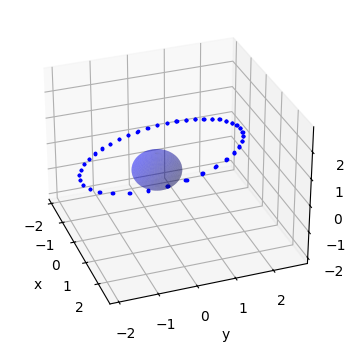

In [26]:
spd = 2*math.pi / (521*60)
initial = (EARTH_R + 25000*1000, 0, np.radians(90-63.4), 0, 0, spd, 0, 10000, 0, 1436*60)
fig_name = "number_8_orbit"
solution = solve_for_3d_initial_inertial(*initial, save_fig=fig_name, plot=False)
radial_coordinates, theta_coordinates, phi_coordinates  = solution.y[0], solution.y[2], solution.y[4]
x = radial_coordinates * np.cos(phi_coordinates)*np.sin(theta_coordinates)
y = radial_coordinates * np.sin(phi_coordinates)*np.sin(theta_coordinates)
z = radial_coordinates * np.cos(theta_coordinates)
animation_3d(x, y, z, save_fig=fig_name)

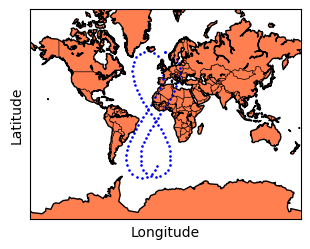

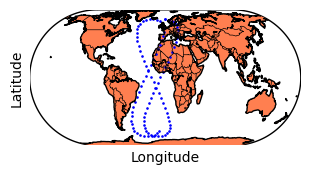

In [27]:
spd = 2*math.pi / (521*60)
initial = (EARTH_R + 25000*1000, 0, np.radians(90-63.4), 0, 0, spd, 0, 10000, 0, 1436*60)
fig_name = "number_8_orbit"
solution = solve_for_3d_ecef(*initial, save_fig=fig_name, plot=False, method="RK45")
time = solution.t
_, theta_coordinates, phi_coordinates  = solution.y[0], solution.y[2], solution.y[4]
phi_adjusted = phi_coordinates - OMEGA * time
animation_2d(colatitude_to_latitude(np.degrees(theta_coordinates)), np.degrees(phi_adjusted), save_fig=fig_name)